# Import, Analyse and Preprocess data

In [16]:
import pandas as pd
import numpy as np
from dataset import pro_encoder, hhblits_encoder, na_encoder, shhblits_encoder
import pickle

In [ ]:
root_dir = 'data/'
hhblits_dir = root_dir + "hhblits/"
X_train = []
for i in ['train']:
    filename = root_dir+i+'.csv'
    df = pd.read_csv(filename)
    # df = df[df['Type_nuc']=='DNA']
    id = df.iloc[:,0].values.tolist(); na_seq = df.loc[:,'Sequence_wild1'].values.tolist()
    mut_seq = df.iloc[:,2].values.tolist(); ori_seq = df.iloc[:,4].values.tolist()
    na_seq = [i.lower() for i in na_seq]
    ori_seq = [i.upper() for i in ori_seq]
    mut_seq = [i.upper() for i in mut_seq]
    pro_ori = pro_encoder(ori_seq)
    pro_mut = pro_encoder(mut_seq)
    na = na_encoder(na_seq)
    hhb_ori, hhb_mut = hhblits_encoder(hhblits_dir,id)
    for i in range(df.shape[0]):
        ori = np.array(pro_ori[i]).flatten(); mut = np.array(pro_ori[i]).flatten()
        nna = np.array(na[i]).flatten()
        sori = np.array(hhb_ori[i]).flatten(); smut = np.array(hhb_mut[i]).flatten()
        X_train.append(np.concatenate((ori,mut,sori,smut,nna)))
    
    y_train = df['ddG(kcal/mol)'].values.tolist()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [17]:
X_test = []
hhblits_dir = root_dir + "hhblits/"
root_dir = 'data/'
for i in ['test']:
    filename = root_dir+i+'.csv'
    df = pd.read_csv(filename)
    # df = df[df['Type_nuc']=='DNA']
    id = df.iloc[:,0].values.tolist(); na_seq = df.loc[:,'Sequence_wild1'].values.tolist()
    mut_seq = df.iloc[:,2].values.tolist(); ori_seq = df.iloc[:,4].values.tolist()
    na_seq = [i.lower() for i in na_seq]
    ori_seq = [i.upper() for i in ori_seq]
    mut_seq = [i.upper() for i in mut_seq]
    pro_ori = pro_encoder(ori_seq)
    pro_mut = pro_encoder(mut_seq)
    na = na_encoder(na_seq)
    hhb_ori, hhb_mut = hhblits_encoder(hhblits_dir,id)
    for i in range(df.shape[0]):
        ori = np.array(pro_ori[i]).flatten(); mut = np.array(pro_ori[i]).flatten()
        nna = np.array(na[i]).flatten()
        sori = np.array(hhb_ori[i]).flatten(); smut = np.array(hhb_mut[i]).flatten()
        X_test.append(np.concatenate((ori,mut,sori,smut,nna)))
    
    y_test = df['ddG(kcal/mol)'].values.tolist()

In [ ]:
y_true = y_test
for i in range(len(y_true)):
    if y_true[i] <1 and y_true[i] > -1:
        y_true[i] = 0
    else:
        y_true[i] = 1

# for i in range(len(y_train)):
#     if y_train[i] <1 and y_train[i] > -1:
#         y_train[i] = 0
#     else:
#         y_train[i] = 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

filelist = os.listdir('result/ml')
modellist = [i for i in filelist if i.endswith('.pkl') and not i.startswith('xgb')]

plt.axis([0,1.1,0,1.1])
# plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of Machine Learning Method')
color = ['r', 'orange','browm', 'pink','gold']
for i in modellist:
    filename = 'result/ml/'+i
    with open(filename,'rb') as f:   
        model = pickle.load((f))
    
    y_score = model.predict(X_test)

    for j in range(len(y_score)):
        if y_score[j] < 1 and y_score[j] > -1:
            y_score[j] = 0
        else:
            y_score[j] = 1

    fpr, tpr, thresholds = roc_curve(y_true,y_score)   
    plt.plot(fpr, tpr, linewidth = 1,label=i)
trans_result = []
with open('result/dl/trans_test_result.txt', 'r') as f:
    line = f.readline().strip()
    line = line.split(', ')
    j = 0
    for i in line:
        if j==len(line)-1:
            break
        trans_result.append(float(i))
        j += 1
y_score = trans_result
for j in range(len(y_score)):
    if y_score[j] < 1 and y_score[j] > -1:
        y_score[j] = 0
    else:
        y_score[j] = 1
fpr, tpr, thresholds = roc_curve(y_true,y_score)   
plt.plot(fpr, tpr, linewidth = 3.0,label='Transformer')
modellist.append('Transformer')
modellist = [i.replace('.pkl', '') for i in modellist]
plt.legend(modellist, loc='lower right')
plt.show()
plt.savefig('result/allroc.png')

In [ ]:
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

filelist = os.listdir('result/dl')
modellist = [i for i in filelist if i.endswith('_test_result.txt')]

plt.axis([0,1.1,0,1.1])
# plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of Deep Learning Method')
# color = ['r', 'orange','browm', 'pink','gold']
for i in modellist:
    trans_result = []
    filename = 'result/dl/'+i
    with open(filename, 'r') as f:
        line = f.readline().strip()
        line = line.split(', ')
        j = 0
        for i in line:
            if j==len(line)-1:
                break
            trans_result.append(float(i))
            j += 1
    y_score = trans_result
    for j in range(len(y_score)):
        if y_score[j] < 1 and y_score[j] > -1:
            y_score[j] = 0
        else:
            y_score[j] = 1
    fpr, tpr, thresholds = roc_curve(y_true,y_score)
    if i.startswith('trans'):
        linewidth = 5.0
    else:
        linewidth = 1.0
    plt.plot(fpr, tpr, linewidth = linewidth)

modellist = [i.replace('_test_result.txt', '') for i in modellist]
plt.legend(modellist, loc='lower right')
plt.show()
plt.savefig('result/alldl.png')

# Decision Tree Model

In [ ]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import GridSearchCV

# paramGride = dict(
#     max_depth = [1,3,5,10,15,20],
#     max_leaf_nodes = [2,3,4,5,10,15,20],)

# dtModel = DecisionTreeRegressor()
# grid = GridSearchCV(
#     dtModel,paramGride,cv = 5,return_train_score = True)
# grid = grid.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

In [18]:
from sklearn.tree import DecisionTreeRegressor
reg_dt = DecisionTreeRegressor()

In [32]:
# reg_dt.fit(X_train,y_train)
with open('result/ml/dt.pkl', 'rb') as f:
    reg_dt = pickle.load(f)

In [21]:
from sklearn.metrics import mean_absolute_error
import math
y_predict = reg_dt.predict(X_test)
mse = mean_absolute_error(y_test, y_predict)                                 
r2_score = reg_dt.score(X_test, y_test) # (.., 2)
math.sqrt(mse), r2_score

(0.832939915636911, 0.16661918745288007)

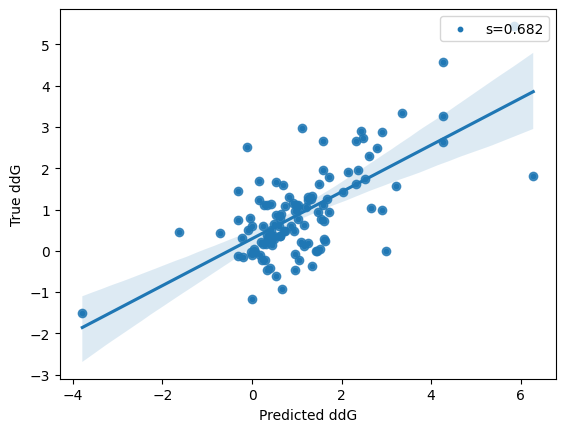

In [33]:
import seaborn as sb
from scipy.stats import pearsonr

from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

dt_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

y_score = reg_dt.predict(X_test)
# for i in range(len(y_score)):
#     if y_score[i] < 1 and y_score[i] > -1:
#         y_score[i] = 0
#     else:
#         y_score[i] = 1
             
# y_score_pro = clf_dt.predict_proba(X_test) # (.., 2)
# y_one_hot = encoder.fit_transform(y_test)
# y_score_one_hot = encoder.fit_transform(y_score)
# dt_prob_list.append(y_score_pro)

# acc_list.append(accuracy_score(y_true, y_score))
# precision_list.append(precision_score(y_true, y_score, average='macro'))
# recall_list.append(recall_score(y_true, y_score, average='macro'))
# f1_list.append(f1_score(y_true, y_score, average='macro'))
# fpr, tpr, thresholds = roc_curve(y_true,y_score)   
# auc_list.append(auc(fpr, tpr))

# plt.plot(fpr, tpr, linewidth = 1,label='AUC=%.3f' % auc(fpr, tpr))
# plt.plot([0,1],[0,1], 'k--')
# mcc = matthews_corrcoef(y_test, y_score)
# print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list), 'MCC: ', mcc)
# print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
# plt.axis([0,1.1,0,1.1])
pcc= pearsonr(y_test, y_score)
plt.scatter(y_score, y_test, s=10, label='s=%.3f'%pcc[0])
plt.xlabel('Predicted ddG')
plt.ylabel('True ddG')
plt.legend(loc="upper right")
sb.regplot(x=y_score, y=y_test)
# plt.title('ROC curve of Decision Tree')
plt.savefig('result/ml/pcc-Decision-Tree.png',dpi=300)
plt.show()

# with open('result/ml/Decision-Tree.txt', 'w+') as f:
#     f.write(str(np.mean(acc_list))+',')
#     f.write(str(np.mean(precision_list))+',')
#     f.write(str(np.mean(recall_list))+',')
#     f.write(str(np.mean(f1_list))+',')
#     f.write(str(np.mean(auc_list))+',')
#     f.write(str(mcc)+',')

In [ ]:
cmdt = confusion_matrix(y_test, y_score)
ConfusionMatrixDisplay(confusion_matrix=cmdt, display_labels=['nondisrupt', 'disrupt']).plot(cmap=plt.cm.Blues)
plt.savefig('result/ml/ConfDecision-Tree.png')

# Random Forest Model

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# paramGride = dict(
#     n_estimators = [3,5,10,15],
#     max_depth = [11,15,20],
#     min_samples_split = [10,20,40,60],)
# # 
# rfModel = RandomForestClassifier()
# grid = GridSearchCV(
#     rfModel,paramGride,cv = 5,return_train_score = True)
# grid = grid.fit(X_train,y_train)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor(n_estimators=10, max_depth=11, min_samples_split=10)

In [27]:
# reg_rf.fit(X_train, y_train)
# with open('result/rf.pkl', 'wb') as f:
#     pickle.dump(reg_rf, f)
with open('result/ml/rf.pkl', 'rb') as f:
    reg_rf = pickle.load(f)

In [29]:
from sklearn.metrics import mean_absolute_error

y_predict = reg_rf.predict(X_test)
mse = mean_absolute_error(y_test, y_predict)                                 
r2_score = reg_rf.score(X_test, y_test) # (.., 2)
math.sqrt(mse), r2_score

(0.7818831903015074, 0.4249084402379574)

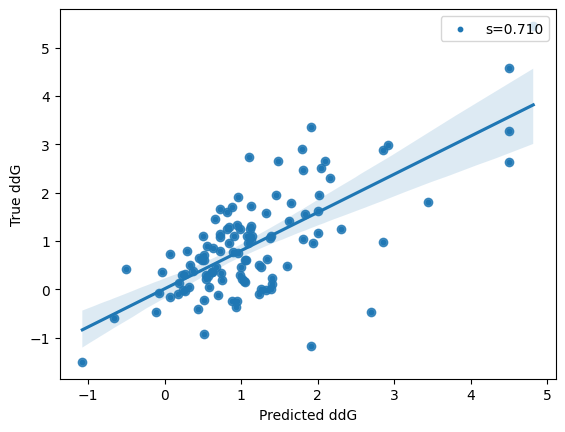

In [34]:
import seaborn as sb
from scipy.stats import pearsonr

from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

dt_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

y_score = reg_rf.predict(X_test)
# for i in range(len(y_score)):
#     if y_score[i] < 1 and y_score[i] > -1:
#         y_score[i] = 0
#     else:
#         y_score[i] = 1
             
# y_score_pro = clf_dt.predict_proba(X_test) # (.., 2)
# y_one_hot = encoder.fit_transform(y_test)
# y_score_one_hot = encoder.fit_transform(y_score)
# dt_prob_list.append(y_score_pro)

# acc_list.append(accuracy_score(y_true, y_score))
# precision_list.append(precision_score(y_true, y_score, average='macro'))
# recall_list.append(recall_score(y_true, y_score, average='macro'))
# f1_list.append(f1_score(y_true, y_score, average='macro'))
# fpr, tpr, thresholds = roc_curve(y_true,y_score)   
# auc_list.append(auc(fpr, tpr))

# plt.plot(fpr, tpr, linewidth = 1,label='AUC=%.3f' % auc(fpr, tpr))
# plt.plot([0,1],[0,1], 'k--')
# mcc = matthews_corrcoef(y_test, y_score)
# print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list), 'MCC: ', mcc)
# print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
# plt.axis([0,1.1,0,1.1])
pcc= pearsonr(y_test, y_score)
plt.scatter(y_score, y_test, s=10, label='s=%.3f'%pcc[0])
plt.xlabel('Predicted ddG')
plt.ylabel('True ddG')
plt.legend(loc="upper right")
sb.regplot(x=y_score, y=y_test)
# plt.title('ROC curve of Decision Tree')
plt.savefig('result/ml/pcc-RF.png',dpi=300)
plt.show()

# with open('result/ml/Decision-Tree.txt', 'w+') as f:
#     f.write(str(np.mean(acc_list))+',')
#     f.write(str(np.mean(precision_list))+',')
#     f.write(str(np.mean(recall_list))+',')
#     f.write(str(np.mean(f1_list))+',')
#     f.write(str(np.mean(auc_list))+',')
#     f.write(str(mcc)+',')

In [ ]:
cmrf = confusion_matrix(y_test, y_score)
ConfusionMatrixDisplay(confusion_matrix=cmrf, display_labels=['nondisrupt','disrupt']).plot(cmap=plt.cm.Blues)
plt.savefig('result/ml/ConfRandom-Forest.png')

# SVM Model

In [ ]:
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV

# paramGride = dict(
#     gamma = [1e-4, 1e-3, 0.01, 0.1, 1, 10],
#     C = [100, 10, 1, 0.1, 1e-2, 1e-3],)

# svmModel = SVC()
# grid = GridSearchCV(
#     svmModel,paramGride,cv = 5,return_train_score = True)
# grid = grid.fit(X_train,y_train)

# print('best_score：%f'% grid.best_score_)
# print('best paramaters:')

# for key in grid.best_params_.keys():
#     print('%s = %s'%(key,grid.best_params_[key]))

In [37]:
from sklearn.svm import SVR
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

In [39]:
reg_svr = SVR()
# reg_svr.fit(X_train,y_train)
# with open('result/svr.pkl', 'wb') as f:
#     pickle.dump(reg_svr, f)
with open('result/ml/svr.pkl', 'rb') as f:
    reg_svr = pickle.load(f)

In [61]:
from sklearn.metrics import mean_absolute_error

y_predict = reg_svr.predict(X_test)
mse = mean_absolute_error(y_test, y_predict)                                 
r2_score = reg_svr.score(X_test, y_test) # (.., 2)
math.sqrt(mse), r2_score

(0.8576156679232009, 0.1237220306045923)

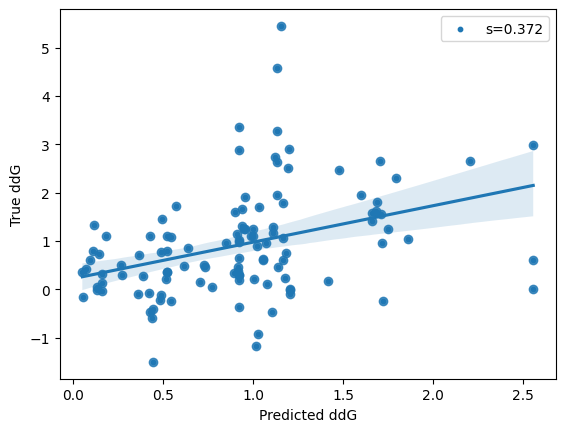

In [62]:
import seaborn as sb
from scipy.stats import pearsonr

from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

# dt_prob_list = []

# acc_list = []
# precision_list = []
# recall_list = []
# f1_list = []
# auc_list = []

# y_score = reg_dt.predict(X_test)
# for i in range(len(y_score)):
#     if y_score[i] < 1 and y_score[i] > -1:
#         y_score[i] = 0
#     else:
#         y_score[i] = 1
             
# y_score_pro = clf_dt.predict_proba(X_test) # (.., 2)
# y_one_hot = encoder.fit_transform(y_test)
# y_score_one_hot = encoder.fit_transform(y_score)
# dt_prob_list.append(y_score_pro)

# acc_list.append(accuracy_score(y_true, y_score))
# precision_list.append(precision_score(y_true, y_score, average='macro'))
# recall_list.append(recall_score(y_true, y_score, average='macro'))
# f1_list.append(f1_score(y_true, y_score, average='macro'))
# fpr, tpr, thresholds = roc_curve(y_true,y_score)   
# auc_list.append(auc(fpr, tpr))

# plt.plot(fpr, tpr, linewidth = 1,label='AUC=%.3f' % auc(fpr, tpr))
# plt.plot([0,1],[0,1], 'k--')
# mcc = matthews_corrcoef(y_test, y_score)
# print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list), 'MCC: ', mcc)
# print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
# plt.axis([0,1.1,0,1.1])
pcc= pearsonr(y_test, y_predict)
plt.scatter(y_predict, y_test, s=10, label='s=%.3f'%pcc[0])
plt.xlabel('Predicted ddG')
plt.ylabel('True ddG')
plt.legend(loc="upper right")
sb.regplot(x=y_predict, y=y_test)
# plt.title('ROC curve of Decision Tree')
plt.savefig('result/ml/pcc-svr.png',dpi=300)
plt.show()

# with open('result/ml/Decision-Tree.txt', 'w+') as f:
#     f.write(str(np.mean(acc_list))+',')
#     f.write(str(np.mean(precision_list))+',')
#     f.write(str(np.mean(recall_list))+',')
#     f.write(str(np.mean(f1_list))+',')
#     f.write(str(np.mean(auc_list))+',')
#     f.write(str(mcc)+',')

In [ ]:
cmex = confusion_matrix(y_test, y_score)
ConfusionMatrixDisplay(confusion_matrix=cmex, display_labels=['nondisrupt','disrupt']).plot(cmap=plt.cm.Blues)
plt.savefig('result/ml/ConfSVR.png')

# knn model

In [43]:
from sklearn.neighbors import KNeighborsRegressor
reg_knn = KNeighborsRegressor()
# reg_knn.fit(X_train, y_train)
# with open('result/knn.pkl', 'wb') as f:
#     pickle.dump(reg_knn, f)
with open('result/ml/knn.pkl', 'rb') as f:
    reg_knn = pickle.load(f)

In [59]:
from sklearn.metrics import mean_absolute_error

y_predict = reg_knn.predict(X_test)
mse = mean_absolute_error(y_test, y_predict)                                 
r2_score = reg_knn.score(X_test, y_test) # (.., 2)
math.sqrt(mse), r2_score

(0.8397916408252705, 0.06806105435843512)

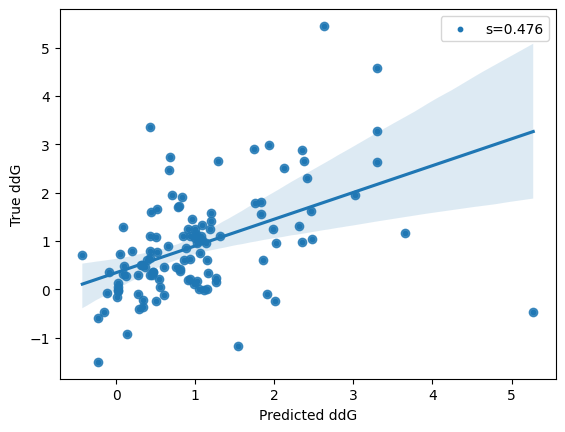

In [60]:
import seaborn as sb
from scipy.stats import pearsonr

from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

dt_prob_list = []

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

y_score = reg_dt.predict(X_test)
# for i in range(len(y_score)):
#     if y_score[i] < 1 and y_score[i] > -1:
#         y_score[i] = 0
#     else:
#         y_score[i] = 1
             
# y_score_pro = clf_dt.predict_proba(X_test) # (.., 2)
# y_one_hot = encoder.fit_transform(y_test)
# y_score_one_hot = encoder.fit_transform(y_score)
# dt_prob_list.append(y_score_pro)

# acc_list.append(accuracy_score(y_true, y_score))
# precision_list.append(precision_score(y_true, y_score, average='macro'))
# recall_list.append(recall_score(y_true, y_score, average='macro'))
# f1_list.append(f1_score(y_true, y_score, average='macro'))
# fpr, tpr, thresholds = roc_curve(y_true,y_score)   
# auc_list.append(auc(fpr, tpr))

# plt.plot(fpr, tpr, linewidth = 1,label='AUC=%.3f' % auc(fpr, tpr))
# plt.plot([0,1],[0,1], 'k--')
# mcc = matthews_corrcoef(y_test, y_score)
# print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list), 'MCC: ', mcc)
# print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
# plt.axis([0,1.1,0,1.1])
pcc= pearsonr(y_test, y_predict)
plt.scatter(y_predict, y_test, s=10, label='s=%.3f'%pcc[0])
plt.xlabel('Predicted ddG')
plt.ylabel('True ddG')
plt.legend(loc="upper right")
sb.regplot(x=y_predict, y=y_test)
# plt.title('ROC curve of Decision Tree')
plt.savefig('result/ml/pcc-knn.png',dpi=300)
plt.show()

# with open('result/ml/Decision-Tree.txt', 'w+') as f:
#     f.write(str(np.mean(acc_list))+',')
#     f.write(str(np.mean(precision_list))+',')
#     f.write(str(np.mean(recall_list))+',')
#     f.write(str(np.mean(f1_list))+',')
#     f.write(str(np.mean(auc_list))+',')
#     f.write(str(mcc)+',')

In [ ]:
cmex = confusion_matrix(y_test, y_score)
ConfusionMatrixDisplay(confusion_matrix=cmex, display_labels=['nondisrupt','disrupt']).plot(cmap=plt.cm.Blues)
plt.savefig('result/ml/ConfKNN.png')

# XGBoost Model

In [48]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# import numpy as np
# other_params = {'eta': 0.3, 'n_estimators': 400, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1,
#                  'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0,
#                  'seed': 33}

# cv_params = {'n_estimators': np.linspace(1, 10, 11, dtype=int)} 
# # cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 

# xgb_model = xgb.XGBClassifier(**other_params)
# gs = GridSearchCV(xgb_model, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1)
# gs.fit(X_train,y_train)
# gs.best_params_

In [50]:
import xgboost as xgb
reg_xgb = xgb.XGBRegressor(n_estimators=10)
# reg_xgb.fit(X_train, y_train)
# with open('result/xgb_new.pkl', 'wb') as f:
#     pickle.dump(reg_xgb, f)
with open('result/ml/xgb.pkl', 'rb') as f:
    reg_xgb = pickle.load(f)

In [51]:
from sklearn.metrics import mean_absolute_error

y_predict = reg_xgb.predict(X_test)
rmse = mean_absolute_error(y_test, y_predict)                                 
r2_score = reg_xgb.score(X_test, y_test) # (.., 2)
math.sqrt(rmse), r2_score

(0.7681169200340969, 0.4506726900915131)

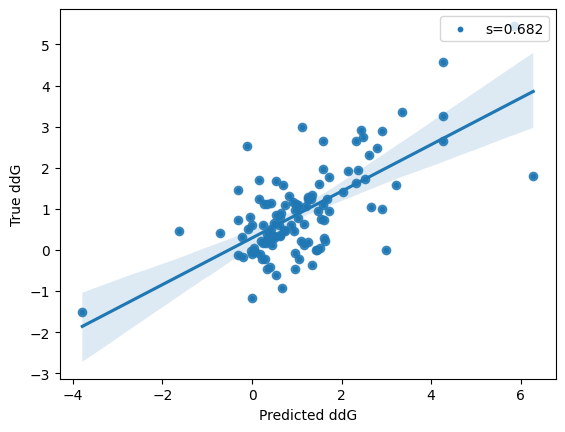

In [52]:
import seaborn as sb
from scipy.stats import pearsonr

from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

# dt_prob_list = []

# acc_list = []
# precision_list = []
# recall_list = []
# f1_list = []
# auc_list = []

y_score = reg_dt.predict(X_test)
# for i in range(len(y_score)):
#     if y_score[i] < 1 and y_score[i] > -1:
#         y_score[i] = 0
#     else:
#         y_score[i] = 1
             
# y_score_pro = clf_dt.predict_proba(X_test) # (.., 2)
# y_one_hot = encoder.fit_transform(y_test)
# y_score_one_hot = encoder.fit_transform(y_score)
# dt_prob_list.append(y_score_pro)

# acc_list.append(accuracy_score(y_true, y_score))
# precision_list.append(precision_score(y_true, y_score, average='macro'))
# recall_list.append(recall_score(y_true, y_score, average='macro'))
# f1_list.append(f1_score(y_true, y_score, average='macro'))
# fpr, tpr, thresholds = roc_curve(y_true,y_score)   
# auc_list.append(auc(fpr, tpr))

# plt.plot(fpr, tpr, linewidth = 1,label='AUC=%.3f' % auc(fpr, tpr))
# plt.plot([0,1],[0,1], 'k--')
# mcc = matthews_corrcoef(y_test, y_score)
# print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list), 'MCC: ', mcc)
# print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
# plt.axis([0,1.1,0,1.1])
pcc= pearsonr(y_test, y_score)
plt.scatter(y_score, y_test, s=10, label='s=%.3f'%pcc[0])
plt.xlabel('Predicted ddG')
plt.ylabel('True ddG')
plt.legend(loc="upper right")
sb.regplot(x=y_score, y=y_test)
# plt.title('ROC curve of Decision Tree')
plt.savefig('result/ml/pcc-xgb.png',dpi=300)
plt.show()

# with open('result/ml/Decision-Tree.txt', 'w+') as f:
#     f.write(str(np.mean(acc_list))+',')
#     f.write(str(np.mean(precision_list))+',')
#     f.write(str(np.mean(recall_list))+',')
#     f.write(str(np.mean(f1_list))+',')
#     f.write(str(np.mean(auc_list))+',')
#     f.write(str(mcc)+',')

In [ ]:
import seaborn as sb
y_score = reg_xgb.predict(X_test)
plt.scatter(y_score, y_test, c='r', s=5)
plt.xlabel('predicted ddG')
plt.ylabel('Estimated ddG')
plt.title('ROC curve of XGB')
sb.regplot(x=y_score, y=y_test)
plt.show()
plt.savefig('result/ml/XGB.png')

In [ ]:
cmex = confusion_matrix(y_true, y_score)
ConfusionMatrixDisplay(confusion_matrix=cmex, display_labels=['nondisrupt','disrupt']).plot(cmap=plt.cm.Blues)
plt.savefig('result/ml/ConfXGB.png')

# Transformer Model

In [54]:
trans_result = []
with open('result/dl/trans_test_result.txt', 'r') as f:
    line = f.readline().strip()
    line = line.split(', ')
    j = 0
    for i in line:
        if j==len(line)-1:
            break
        trans_result.append(float(i))
        j += 1

print(len(trans_result))

112


In [63]:
from sklearn.metrics import mean_absolute_error

y_predict = np.array(trans_result)
rmse = mean_absolute_error(y_test, y_predict)                                 
# r2_score = reg_knn.score(X_test, y_test) # (.., 2)
math.sqrt(rmse), r2_score

(0.7612361473715253, 0.1237220306045923)

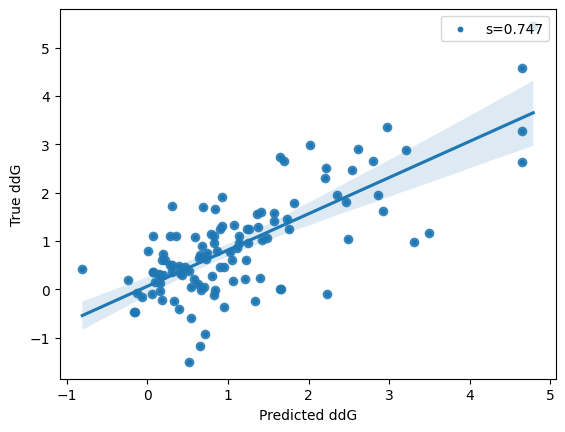

In [66]:
import seaborn as sb
from scipy.stats import pearsonr

from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

# dt_prob_list = []

# acc_list = []
# precision_list = []
# recall_list = []
# f1_list = []
# auc_list = []

# y_score = reg_dt.predict(X_test)
# for i in range(len(y_score)):
#     if y_score[i] < 1 and y_score[i] > -1:
#         y_score[i] = 0
#     else:
#         y_score[i] = 1
             
# y_score_pro = clf_dt.predict_proba(X_test) # (.., 2)
# y_one_hot = encoder.fit_transform(y_test)
# y_score_one_hot = encoder.fit_transform(y_score)
# dt_prob_list.append(y_score_pro)

# acc_list.append(accuracy_score(y_true, y_score))
# precision_list.append(precision_score(y_true, y_score, average='macro'))
# recall_list.append(recall_score(y_true, y_score, average='macro'))
# f1_list.append(f1_score(y_true, y_score, average='macro'))
# fpr, tpr, thresholds = roc_curve(y_true,y_score)   
# auc_list.append(auc(fpr, tpr))

# plt.plot(fpr, tpr, linewidth = 1,label='AUC=%.3f' % auc(fpr, tpr))
# plt.plot([0,1],[0,1], 'k--')
# mcc = matthews_corrcoef(y_test, y_score)
# print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list), 'MCC: ', mcc)
# print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
# plt.axis([0,1.1,0,1.1])
pcc= pearsonr(y_test, y_predict)
plt.scatter(y_predict, y_test, s=10, label='s=%.3f'%pcc[0])
plt.xlabel('Predicted ddG')
plt.ylabel('True ddG')
plt.legend(loc="upper right")
sb.regplot(x=y_predict, y=y_test)
# plt.title('ROC curve of Decision Tree')
plt.savefig('result/ml/pcc-trans.png',dpi=300)
plt.show()

# with open('result/ml/Decision-Tree.txt', 'w+') as f:
#     f.write(str(np.mean(acc_list))+',')
#     f.write(str(np.mean(precision_list))+',')
#     f.write(str(np.mean(recall_list))+',')
#     f.write(str(np.mean(f1_list))+',')
#     f.write(str(np.mean(auc_list))+',')
#     f.write(str(mcc)+',')

In [ ]:
cmdt = confusion_matrix(y_true, y_score)
ConfusionMatrixDisplay(confusion_matrix=cmdt, display_labels=['nondisrupt', 'disrupt']).plot(cmap=plt.cm.Blues)
plt.savefig('result/dl/ConfTrans.png')

# MLP Model

In [69]:
trans_result = []
with open('result/dl/mlp_test_result.txt', 'r') as f:
    line = f.readline().strip()
    line = line.split(', ')
    j = 0
    for i in line:
        if j==len(line)-1:
            break
        trans_result.append(float(i))
        j += 1

print(len(trans_result))

112


In [70]:
from sklearn.metrics import mean_absolute_error

y_predict = np.array(trans_result).T
rmse = mean_absolute_error(y_test, y_predict)                                 
r2_score = reg_knn.score(X_test, y_test) # (.., 2)
math.sqrt(rmse), r2_score

(0.8746128872210756, 0.06806105435843512)

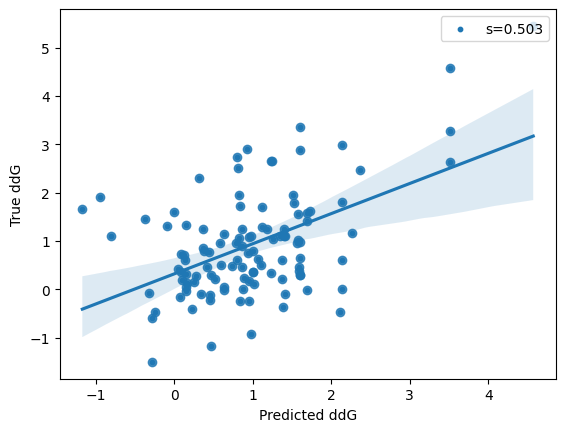

In [71]:
import seaborn as sb
from scipy.stats import pearsonr

from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

# dt_prob_list = []

# acc_list = []
# precision_list = []
# recall_list = []
# f1_list = []
# auc_list = []

# y_score = reg_dt.predict(X_test)
# for i in range(len(y_score)):
#     if y_score[i] < 1 and y_score[i] > -1:
#         y_score[i] = 0
#     else:
#         y_score[i] = 1
             
# y_score_pro = clf_dt.predict_proba(X_test) # (.., 2)
# y_one_hot = encoder.fit_transform(y_test)
# y_score_one_hot = encoder.fit_transform(y_score)
# dt_prob_list.append(y_score_pro)

# acc_list.append(accuracy_score(y_true, y_score))
# precision_list.append(precision_score(y_true, y_score, average='macro'))
# recall_list.append(recall_score(y_true, y_score, average='macro'))
# f1_list.append(f1_score(y_true, y_score, average='macro'))
# fpr, tpr, thresholds = roc_curve(y_true,y_score)   
# auc_list.append(auc(fpr, tpr))

# plt.plot(fpr, tpr, linewidth = 1,label='AUC=%.3f' % auc(fpr, tpr))
# plt.plot([0,1],[0,1], 'k--')
# mcc = matthews_corrcoef(y_test, y_score)
# print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list), 'MCC: ', mcc)
# print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
# plt.axis([0,1.1,0,1.1])
pcc= pearsonr(y_test, y_predict)
plt.scatter(y_predict, y_test, s=10, label='s=%.3f'%pcc[0])
plt.xlabel('Predicted ddG')
plt.ylabel('True ddG')
plt.legend(loc="upper right")
sb.regplot(x=y_predict, y=y_test)
# plt.title('ROC curve of Decision Tree')
plt.savefig('result/dl/pcc-mlp.png',dpi=300)
plt.show()

# with open('result/ml/Decision-Tree.txt', 'w+') as f:
#     f.write(str(np.mean(acc_list))+',')
#     f.write(str(np.mean(precision_list))+',')
#     f.write(str(np.mean(recall_list))+',')
#     f.write(str(np.mean(f1_list))+',')
#     f.write(str(np.mean(auc_list))+',')
#     f.write(str(mcc)+',')

In [ ]:
cmdt = confusion_matrix(y_true, y_score)
ConfusionMatrixDisplay(confusion_matrix=cmdt, display_labels=['nondisrupt', 'disrupt']).plot(cmap=plt.cm.Blues)
plt.savefig('result/dl/ConfMLP.png')

# CNN Model

In [72]:
trans_result = []
with open('result/dl/cnn_test_result.txt', 'r') as f:
    line = f.readline().strip()
    line = line.split(', ')
    j = 0
    for i in line:
        if j==len(line)-1:
            break
        trans_result.append(float(i))
        j += 1

print(len(trans_result))

112


In [73]:
from sklearn.metrics import mean_absolute_error

y_predict = np.array(trans_result)
rmse = mean_absolute_error(y_test, y_predict)                                 
r2_score = reg_knn.score(X_test, y_test) # (.., 2)
math.sqrt(rmse), r2_score

(0.8248323293014773, 0.06806105435843512)

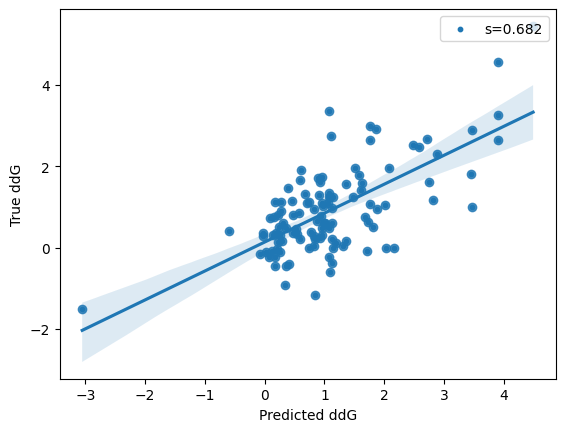

In [74]:
import seaborn as sb
from scipy.stats import pearsonr

from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

# dt_prob_list = []

# acc_list = []
# precision_list = []
# recall_list = []
# f1_list = []
# auc_list = []

# y_score = reg_dt.predict(X_test)
# for i in range(len(y_score)):
#     if y_score[i] < 1 and y_score[i] > -1:
#         y_score[i] = 0
#     else:
#         y_score[i] = 1
             
# y_score_pro = clf_dt.predict_proba(X_test) # (.., 2)
# y_one_hot = encoder.fit_transform(y_test)
# y_score_one_hot = encoder.fit_transform(y_score)
# dt_prob_list.append(y_score_pro)

# acc_list.append(accuracy_score(y_true, y_score))
# precision_list.append(precision_score(y_true, y_score, average='macro'))
# recall_list.append(recall_score(y_true, y_score, average='macro'))
# f1_list.append(f1_score(y_true, y_score, average='macro'))
# fpr, tpr, thresholds = roc_curve(y_true,y_score)   
# auc_list.append(auc(fpr, tpr))

# plt.plot(fpr, tpr, linewidth = 1,label='AUC=%.3f' % auc(fpr, tpr))
# plt.plot([0,1],[0,1], 'k--')
# mcc = matthews_corrcoef(y_test, y_score)
# print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list), 'MCC: ', mcc)
# print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
# plt.axis([0,1.1,0,1.1])
pcc= pearsonr(y_test, y_predict)
plt.scatter(y_predict, y_test, s=10, label='s=%.3f'%pcc[0])
plt.xlabel('Predicted ddG')
plt.ylabel('True ddG')
plt.legend(loc="upper right")
sb.regplot(x=y_predict, y=y_test)
# plt.title('ROC curve of Decision Tree')
plt.savefig('result/dl/pcc-mlp.png',dpi=300)
plt.show()

# with open('result/ml/Decision-Tree.txt', 'w+') as f:
#     f.write(str(np.mean(acc_list))+',')
#     f.write(str(np.mean(precision_list))+',')
#     f.write(str(np.mean(recall_list))+',')
#     f.write(str(np.mean(f1_list))+',')
#     f.write(str(np.mean(auc_list))+',')
#     f.write(str(mcc)+',')

In [ ]:
cmdt = confusion_matrix(y_true, y_score)
ConfusionMatrixDisplay(confusion_matrix=cmdt, display_labels=['nondisrupt', 'disrupt']).plot(cmap=plt.cm.Blues)
plt.savefig('result/dl/ConfCNN.png')

# LSTM Model

In [75]:
trans_result = []
with open('result/dl/lstm_test_result.txt', 'r') as f:
    line = f.readline().strip()
    line = line.split(', ')
    j = 0
    for i in line:
        if j==len(line)-1:
            break
        trans_result.append(float(i))
        j += 1

print(len(trans_result))

112


In [76]:
from sklearn.metrics import mean_absolute_error

y_predict = np.array(trans_result)
rmse = mean_absolute_error(y_test, y_predict)                                 
r2_score = reg_knn.score(X_test, y_test) # (.., 2)
math.sqrt(rmse), r2_score

(0.8088927649339144, 0.06806105435843512)

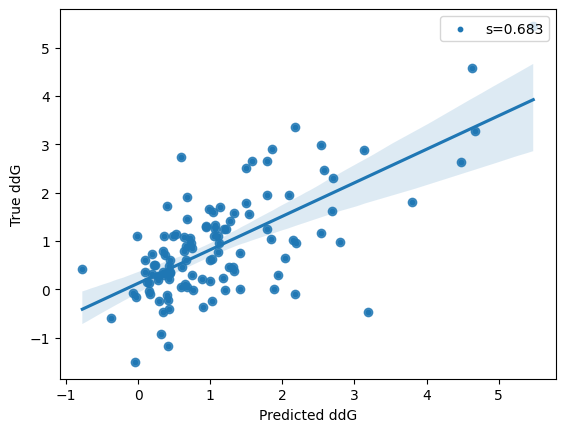

In [78]:
import seaborn as sb
from scipy.stats import pearsonr

from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

# dt_prob_list = []

# acc_list = []
# precision_list = []
# recall_list = []
# f1_list = []
# auc_list = []

# y_score = reg_dt.predict(X_test)
# for i in range(len(y_score)):
#     if y_score[i] < 1 and y_score[i] > -1:
#         y_score[i] = 0
#     else:
#         y_score[i] = 1
             
# y_score_pro = clf_dt.predict_proba(X_test) # (.., 2)
# y_one_hot = encoder.fit_transform(y_test)
# y_score_one_hot = encoder.fit_transform(y_score)
# dt_prob_list.append(y_score_pro)

# acc_list.append(accuracy_score(y_true, y_score))
# precision_list.append(precision_score(y_true, y_score, average='macro'))
# recall_list.append(recall_score(y_true, y_score, average='macro'))
# f1_list.append(f1_score(y_true, y_score, average='macro'))
# fpr, tpr, thresholds = roc_curve(y_true,y_score)   
# auc_list.append(auc(fpr, tpr))

# plt.plot(fpr, tpr, linewidth = 1,label='AUC=%.3f' % auc(fpr, tpr))
# plt.plot([0,1],[0,1], 'k--')
# mcc = matthews_corrcoef(y_test, y_score)
# print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list), 'MCC: ', mcc)
# print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
# plt.axis([0,1.1,0,1.1])
pcc= pearsonr(y_test, y_predict)
plt.scatter(y_predict, y_test, s=10, label='s=%.3f'%pcc[0])
plt.xlabel('Predicted ddG')
plt.ylabel('True ddG')
plt.legend(loc="upper right")
sb.regplot(x=y_predict, y=y_test)
# plt.title('ROC curve of Decision Tree')
plt.savefig('result/dl/pcc-lstm.png',dpi=300)
plt.show()

# with open('result/ml/Decision-Tree.txt', 'w+') as f:
#     f.write(str(np.mean(acc_list))+',')
#     f.write(str(np.mean(precision_list))+',')
#     f.write(str(np.mean(recall_list))+',')
#     f.write(str(np.mean(f1_list))+',')
#     f.write(str(np.mean(auc_list))+',')
#     f.write(str(mcc)+',')

In [ ]:
cmdt = confusion_matrix(y_true, y_score)
ConfusionMatrixDisplay(confusion_matrix=cmdt, display_labels=['nondisrupt', 'disrupt']).plot(cmap=plt.cm.Blues)
plt.savefig('result/dl/ConfLSTM.png')

# Bi-LSTM Model

In [79]:
trans_result = []
with open('result/dl/blstm_test_result.txt', 'r') as f:
    line = f.readline().strip()
    line = line.split(', ')
    j = 0
    for i in line:
        if j==len(line)-1:
            break
        trans_result.append(float(i))
        j += 1

print(len(trans_result))

112


In [80]:
from sklearn.metrics import mean_absolute_error

y_predict = np.array(trans_result).T
rmse = mean_absolute_error(y_test, y_predict)                                 
# r2_score = reg_knn.score(X_test, y_test) # (.., 2)
math.sqrt(rmse), r2_score

(0.8157067018073654, 0.06806105435843512)

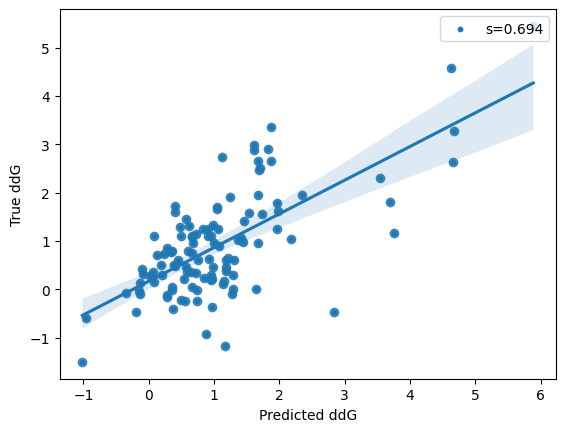

In [81]:
import seaborn as sb
from scipy.stats import pearsonr

from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

# dt_prob_list = []

# acc_list = []
# precision_list = []
# recall_list = []
# f1_list = []
# auc_list = []

# y_score = reg_dt.predict(X_test)
# for i in range(len(y_score)):
#     if y_score[i] < 1 and y_score[i] > -1:
#         y_score[i] = 0
#     else:
#         y_score[i] = 1
             
# y_score_pro = clf_dt.predict_proba(X_test) # (.., 2)
# y_one_hot = encoder.fit_transform(y_test)
# y_score_one_hot = encoder.fit_transform(y_score)
# dt_prob_list.append(y_score_pro)

# acc_list.append(accuracy_score(y_true, y_score))
# precision_list.append(precision_score(y_true, y_score, average='macro'))
# recall_list.append(recall_score(y_true, y_score, average='macro'))
# f1_list.append(f1_score(y_true, y_score, average='macro'))
# fpr, tpr, thresholds = roc_curve(y_true,y_score)   
# auc_list.append(auc(fpr, tpr))

# plt.plot(fpr, tpr, linewidth = 1,label='AUC=%.3f' % auc(fpr, tpr))
# plt.plot([0,1],[0,1], 'k--')
# mcc = matthews_corrcoef(y_test, y_score)
# print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list), 'MCC: ', mcc)
# print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
# plt.axis([0,1.1,0,1.1])
pcc= pearsonr(y_test, y_predict)
plt.scatter(y_predict, y_test, s=10, label='s=%.3f'%pcc[0])
plt.xlabel('Predicted ddG')
plt.ylabel('True ddG')
plt.legend(loc="upper right")
sb.regplot(x=y_predict, y=y_test)
# plt.title('ROC curve of Decision Tree')
plt.savefig('result/dl/pcc-blstm.png',dpi=300)
plt.show()

# with open('result/ml/Decision-Tree.txt', 'w+') as f:
#     f.write(str(np.mean(acc_list))+',')
#     f.write(str(np.mean(precision_list))+',')
#     f.write(str(np.mean(recall_list))+',')
#     f.write(str(np.mean(f1_list))+',')
#     f.write(str(np.mean(auc_list))+',')
#     f.write(str(mcc)+',')

In [ ]:
cmdt = confusion_matrix(y_true, y_score)
ConfusionMatrixDisplay(confusion_matrix=cmdt, display_labels=['nondisrupt', 'disrupt']).plot(cmap=plt.cm.Blues)
plt.savefig('result/dl/ConfBLSTM.png')

In [ ]:
import os

filelist = os.listdir('result/ml')
modellist = [i for i in filelist if i.endswith('.pkl')]

plt.axis([0,1.1,0,1.1])
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of Machine Learning Method')

for i in modellist:
    with open(i,'rb') as f:
        filename = 'result/ml/'+i
        model = pickle.load((filename))
    
    y_score = model.predict(X_test)

    for i in range(len(y_score)):
        if y_score[i] < 1 and y_score[i] > -1:
            y_score[i] = 0
        else:
            y_score[i] = 1

    fpr, tpr, thresholds = roc_curve(y_true,y_score)   
    auc_list.append(auc(fpr, tpr))
    plt.plot(fpr, tpr, linewidth = 1,label='%s: AUC=%.3f' %i.strip('.pkl')%auc(fpr, tpr),linewith=3.0)
plt.show()
plt.savefig('result/allroc.png')